In [13]:
import sys
import os
from datetime import datetime

import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier

from Utils.data_utils import load_preprocessed_data_from_folder



In [14]:
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))

# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.475227,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.676487,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.558823,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0
...,...,...,...,...,...,...,...,...,...,...
7987,0.447629,0.509255,0.447512,0.688031,0.550855,0.167116,0.424914,0.476354,0.416496,1.0
7988,0.569804,0.477218,0.259559,0.537921,0.524618,0.188404,0.411696,0.596761,0.431539,1.0
7989,0.389444,0.550602,0.231928,0.574340,0.480976,0.503006,0.452893,0.767213,0.707229,1.0
7990,0.488616,0.451909,0.582194,0.416325,0.478834,0.514122,0.498098,0.549356,0.537085,1.0


In [15]:
TEST_SIZE = 0.2
NUM_FOLDS = 5

train_df, test_df = train_test_split(data, test_size=TEST_SIZE)
train_df, test_df

(            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
 2101  0.433656  0.329324  0.238589     0.605991  0.621597      0.363410   
 7389  0.551867  0.584340  0.277692     0.573549  0.447035      0.153414   
 3785  0.532655  0.782049  0.505106     0.104266  0.676242      0.704930   
 2527  0.586924  0.335604  0.510624     0.491249  0.617677      0.344993   
 3937  0.506907  0.620771  0.187233     0.564650  0.475614      0.474320   
 ...        ...       ...       ...          ...       ...           ...   
 1987  0.483974  0.387899  0.249637     0.448699  0.607993      0.728319   
 1986  0.473589  0.411649  0.365099     0.387741  0.595490      0.411665   
 5862  0.801367  0.689721  0.353836     0.213097  0.593833      0.336688   
 5214  0.502625  0.591011  0.221512     0.628280  0.606477      0.538702   
 3889  0.432702  0.664821  0.731411     0.476821  0.553039      0.377284   
 
       Organic_carbon  Trihalomethanes  Turbidity  Potability  
 2101        0.567951 

In [16]:
train_y = train_df['Potability']
train_x = train_df.drop('Potability', axis=1)

test_y = test_df['Potability']
test_x = test_df.drop('Potability', axis=1)
train_x

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
2101,0.433656,0.329324,0.238589,0.605991,0.621597,0.363410,0.567951,0.808870,0.678074
7389,0.551867,0.584340,0.277692,0.573549,0.447035,0.153414,0.366290,0.455472,0.335618
3785,0.532655,0.782049,0.505106,0.104266,0.676242,0.704930,0.368178,0.363156,0.502277
2527,0.586924,0.335604,0.510624,0.491249,0.617677,0.344993,0.587911,0.438584,0.583509
3937,0.506907,0.620771,0.187233,0.564650,0.475614,0.474320,0.477613,0.409890,0.399205
...,...,...,...,...,...,...,...,...,...
1987,0.483974,0.387899,0.249637,0.448699,0.607993,0.728319,0.571592,0.449336,0.296378
1986,0.473589,0.411649,0.365099,0.387741,0.595490,0.411665,0.520808,0.426231,0.705465
5862,0.801367,0.689721,0.353836,0.213097,0.593833,0.336688,0.521243,0.517178,0.812930
5214,0.502625,0.591011,0.221512,0.628280,0.606477,0.538702,0.483674,0.555365,0.347017


In [17]:
params = {
    'objective': 'binary:logistic',  # binary classification problem
    'eval_metric': 'logloss',         # evaluation metric: logarithmic loss
    'eta': 0.1,                       # learning rate
    'max_depth': 6,                   # maximum depth of a tree
    'subsample': 0.8,                 # subsample ratio of the training instances
    'colsample_bytree': 0.8,          # subsample ratio of columns when constructing each tree
    'seed': 42                        # random seed for reproducibility
}

# Train the XGBoost model
num_round = 100

In [18]:
bst = xgb.train(params, xgb.DMatrix(train_df.drop('Potability', axis=1), label=train_y), num_round)


In [19]:
y_pred_proba = bst.predict(xgb.DMatrix(test_x))
y_pred = np.round(y_pred_proba)
f1 = f1_score(test_y, y_pred)

print("F1 Score:", f1)

F1 Score: 0.8558558558558559


In [20]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [21]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    nthread=-1)

In [22]:
from sklearn.model_selection import StratifiedKFold

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

In [23]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [24]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='f1', n_jobs=4, cv=skf.split(train_df.drop('Potability', axis=1),train_y), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(train_df.drop('Potability', axis=1), train_y)
timer(start_time)

Fitting 3 folds for each of 5 candidates, totalling 15 fits

 Time taken: 0 hours 0 minutes and 11.74 seconds.


In [25]:
import pandas as pd

print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 All results:
{'mean_fit_time': array([0.20704667, 0.49196331, 0.41129128, 0.13286026, 0.35629725]), 'std_fit_time': array([0.00124291, 0.02199749, 0.00859089, 0.006815  , 0.0016681 ]), 'mean_score_time': array([0.00684317, 0.01301606, 0.01184408, 0.00717958, 0.01000865]), 'std_score_time': array([0.00094381, 0.00070662, 0.00125059, 0.00047211, 0.00071386]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dt

In [26]:
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 1.5,
 'colsample_bytree': 0.8}

In [27]:
ideal_xgb = XGBClassifier(**random_search.best_params_)
ideal_xgb.fit(train_df.drop('Potability', axis=1), train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [30]:
y_test_pred = pd.Series(ideal_xgb.predict(test_df.drop('Potability', axis=1)))
f1_score_test = f1_score(test_y, y_test_pred)
f1_score_test

0.865992414664981

In [31]:
labels = ['Not Potable','Water Potable']
cm = confusion_matrix(test_y, y_pred,labels=[0, 1])

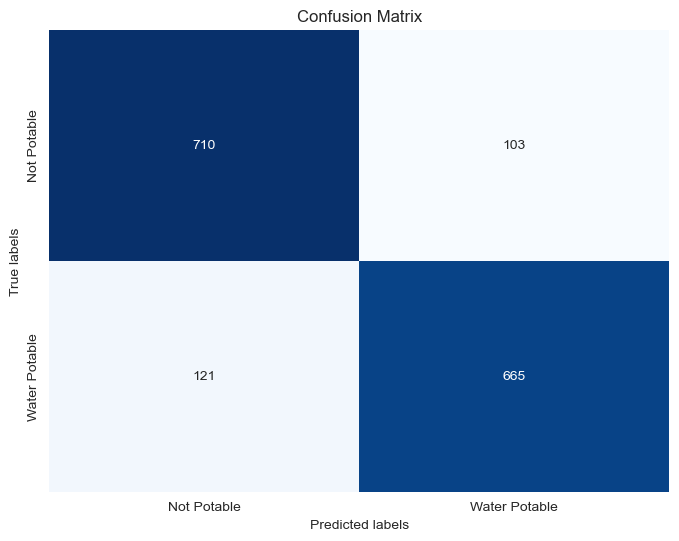

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [33]:
calibrated_xgb = CalibratedClassifierCV(ideal_xgb, cv=NUM_FOLDS)
calibrated_xgb.fit(train_df.drop('Potability', axis=1), train_y)
test_x = test_df.drop('Potability', axis=1)
print(f'Calibrated SVC test accuracy: {calibrated_xgb.score(test_x, test_y):0.2%}')

Calibrated SVC test accuracy: 89.49%


In [34]:
y_proba = calibrated_xgb.predict_proba(test_x)[:, 1]
y_proba

array([0.30844411, 0.15308777, 0.94392072, ..., 0.95699873, 0.03335287,
       0.04248639])

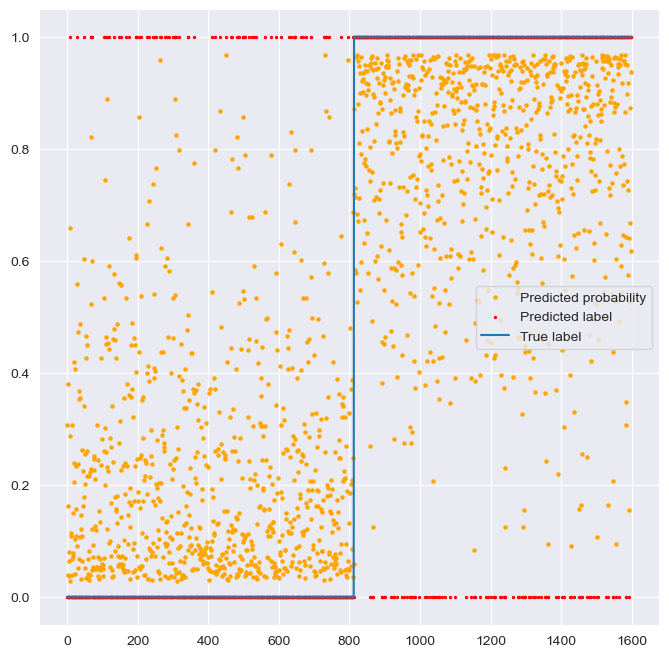

In [35]:
# Create a zipped array of sample index, predicted proability and true label
results = np.column_stack((calibrated_xgb.predict_proba(test_x)[:, 1], calibrated_xgb.predict(test_x), test_y))

# Sort by true label
results = results[results[:, 2].argsort()]

# Plot the predicted probabilities & true labels

plt.figure(figsize=(8, 8))
plt.scatter(range(len(results)), results[:, 0], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 1], label='Predicted label', c='red', s=2)
plt.plot(results[:, 2], label='True label')
plt.legend()

plt.show()

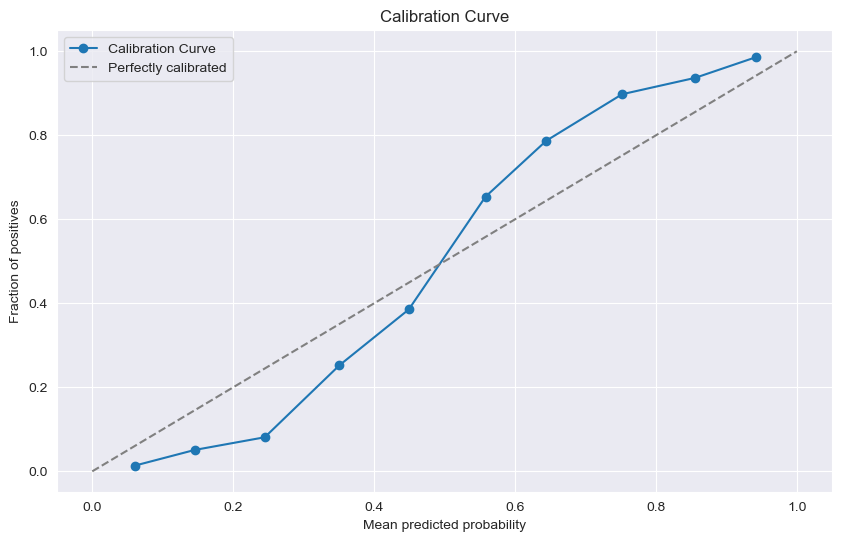

In [36]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(test_y, y_proba, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()